In [1]:
# Black Litterman  model  : step by step 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import os
from dateutil.relativedelta import relativedelta

plt.style.use('seaborn')

FONT_NAME = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=FONT_NAME)


folder_dir = 'C:/Users/nws71/OneDrive/바탕 화면/1-2/심화프로그래밍(파이썬)/과제'
DATA_FILE = "KRX300_수정주가_실습 1.xlsx"

data_wb = pd.ExcelFile(folder_dir + "/" + DATA_FILE)

adj_price = data_wb.parse("Sheet3",  index_col=0)



In [13]:
universe =adj_price[['LG전자','현대차','NAVER','삼성물산','SK텔레콤','KT&G']].loc['2015-01-01':'2022-08-31']
monthly_returns=universe.resample('M').last().pct_change(1)
print(monthly_returns.head(6))


                LG전자       현대차     NAVER      삼성물산     SK텔레콤      KT&G
2015-01-31       NaN       NaN       NaN       NaN       NaN       NaN
2015-02-28  0.016447 -0.053097 -0.076812  0.191176 -0.008644 -0.002494
2015-03-31 -0.046926  0.049844  0.015130 -0.077160 -0.048875  0.108750
2015-04-30  0.025467  0.002967 -0.031297  0.060201  0.053216  0.072153
2015-05-31 -0.084437 -0.065089 -0.063079  0.211356 -0.141120  0.013670
2015-06-30 -0.146474 -0.139241  0.041050 -0.075521  0.014202 -0.015560


In [14]:
# 유니버스 내 각 자산비중


w_mkt=np.array([0.1,0.3,0.25,0.16,0.09,0.1])

display(w_mkt)        


array([0.1 , 0.3 , 0.25, 0.16, 0.09, 0.1 ])

In [15]:
# 자산별 기대수익률 계산

erk =monthly_returns.mean()*12

print(erk)






LG전자     0.134507
현대차      0.066243
NAVER    0.116272
삼성물산     0.026999
SK텔레콤    0.028111
KT&G     0.021527
dtype: float64


In [16]:
# 공본산 구하기

Sigma = monthly_returns.cov()*12
print(Sigma)

           LG전자       현대차     NAVER      삼성물산     SK텔레콤      KT&G
LG전자   0.148066  0.048504  0.034077  0.035128  0.024171  0.001729
현대차    0.048504  0.099635  0.022995  0.014120  0.026735  0.011621
NAVER  0.034077  0.022995  0.098043  0.018678  0.011049 -0.000604
삼성물산   0.035128  0.014120  0.018678  0.087265  0.009079 -0.003178
SK텔레콤  0.024171  0.026735  0.011049  0.009079  0.045233  0.010370
KT&G   0.001729  0.011621 -0.000604 -0.003178  0.010370  0.034119


In [17]:
# 람다 구하기

# 포트폴리오 기대수익률
expected_portfolio_return = monthly_returns.mean().multiply(w_mkt).sum()*12  

# 포트폴리오 분산
portfolio_variance = w_mkt.dot(Sigma).dot(w_mkt)

lambd = expected_portfolio_return / portfolio_variance                       

print(expected_portfolio_return,portfolio_variance,lambd )

0.07139398440619747 0.034978198331094196 2.041099536642833


In [18]:
#  균형기대 수익률 구하기

Pi = lambd*Sigma.dot(w_mkt)

print(Pi)






LG전자     0.093576
현대차      0.094538
NAVER    0.079071
삼성물산     0.054864
SK텔레콤    0.040333
KT&G     0.014991
dtype: float64


In [19]:
#  View 1 :  삼성물산의  수익률이 2%가 될 것으로 예상  
#  View 2 :  LG전자 수익률이  현대차 수익률보다 3% 높을 것으로 예상 
#  View 3 :  NAVER 수익률이  SK텔레콤, KT&G 수익률보다 1% 높을 것으로 예상


# 전망 갯수 K와 vIew 벡터 설정
K=3
Q = np.array([0.02, 0.03, 0.01])
assert Q.shape == (K,)


In [20]:
# Picking Matrix 생성 (뷰에 포함된 자산 명시)



N=len(w_mkt)

P = np.array([
    [0, 0, 0, 1, 0, 0 ],
    [1, -1, 0, 0, 0, 0],
    [0, 0, 1, 0, -0.5, -0.5]])

assert P.shape == (K, N)
print(P)

[[ 0.   0.   0.   1.   0.   0. ]
 [ 1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.  -0.5 -0.5]]


In [21]:
# view의 불확실성을 나타내는 행렬( Uncertainty Matrix of Views)


tau=1

Omega = tau*P.dot(Sigma).dot(P.T)*np.eye(K) 

print(Omega)










[[0.08726477 0.         0.        ]
 [0.         0.15069238 0.        ]
 [0.         0.         0.11262086]]


In [16]:
# 위 과정을 종합하여 포트폴리오내 자산별 전망결합 기대수익률을 구한다.


ER = Pi + tau*Sigma.dot(P.T).dot(np.linalg.inv(P.dot(tau*Sigma).dot(P.T) + Omega).dot(Q - P.dot(Pi)))

print(ER)




LG전자     0.095430
현대차      0.084555
NAVER    0.060083
삼성물산     0.037352
SK텔레콤    0.041213
KT&G     0.018474
dtype: float64


In [17]:
# 전망결합기대수익률

sub_1 = np.linalg.inv(np.dot(tau, Sigma))
sub_2 = np.dot(np.dot(np.transpose(P), np.linalg.inv(Omega)), P)
sub_3 = np.dot(np.linalg.inv(np.dot(tau, Sigma)), Pi)
sub_4 = np.dot(np.dot(np.transpose(P), np.linalg.inv(Omega)), Q)
Pi_adj = np.dot(np.linalg.inv(sub_1 + sub_2), (sub_3 + sub_4))


Pi_adjs = pd.Series(Pi_adj, index=monthly_returns.columns)
print(Pi_adjs)


LG전자     0.095430
현대차      0.084555
NAVER    0.060083
삼성물산     0.037352
SK텔레콤    0.041213
KT&G     0.018474
dtype: float64


In [18]:
# 투자비중 산출

w_hat = lambd*np.linalg.inv(Sigma).dot(ER)
w_hat = pd.Series(w_hat / w_hat.sum(), index=monthly_returns.columns)
w_dif=w_hat - w_mkt
display(w_hat,w_mkt,w_dif)



LG전자     0.179684
현대차      0.263490
NAVER    0.179435
삼성물산     0.069334
SK텔레콤    0.148489
KT&G     0.159568
dtype: float64

array([0.1 , 0.3 , 0.25, 0.16, 0.09, 0.1 ])

LG전자     0.079684
현대차     -0.036510
NAVER   -0.070565
삼성물산    -0.090666
SK텔레콤    0.058489
KT&G     0.059568
dtype: float64

<AxesSubplot:>

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


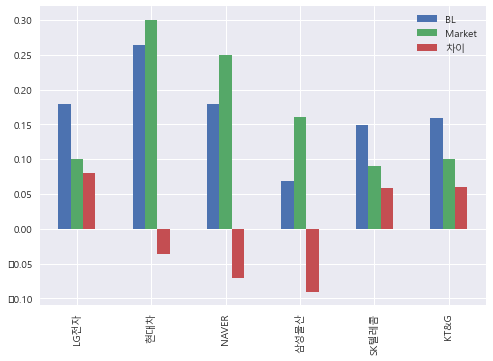

In [19]:
#  모형 결과치 비중 (BL-Market)

ww=np.concatenate( [w_hat.T,w_mkt.T,w_dif.T] )
b = np.reshape(ww,(3,6))
wdif=pd.DataFrame(b.T,columns=['BL','Market','차이'],index=monthly_returns.columns)
wdif.plot.bar()